<a href="https://colab.research.google.com/github/sunnyshi0310/KoopmanRobo/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Koopman Operator Theory in Robot Learning

The script will go through the main process of implementing the Koopman theory in robotic platforms for modeling and control. The example with a differential-drive robotic model (DD-R) is shown below. For each part, we only show the most common and simple way to illustrate the idea, please refer to the paper for more details,.

In [1]:
# Import dependencies.
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv, eig, solve_discrete_are
from scipy import linalg
import time

# Set random seed for reproducibility
np.random.seed(0)

### Step 1: Determine States/Inputs and Collect Data for Training
For your robotic system, the first step is to define the states and inputs. The state is determined by what you can measure (e.g., sensors) and what is relevant to your task (e.g., if you need to control position, then position must be in the state). The input is typically the low-level command sent to the actuators (e.g., motor voltages or torques), and its design should account for the system's actuation limits. Note that the Koopman operator can learn the relationship between states and inputs at virtually any level of control. Therefore, the choice of which control layer to use—from high-level commands like body velocity for a quadruped robot, to mid-level joint angles, down to low-level motor signals—depends on your specific task requirements and system capabilities.


In [2]:
# State/Input choice for the DD-R:
# We choose state x = [x_pos, y_pos, theta] (robot pose in plane)
# Input u = [v, omega] (linear velocity, angular velocity)
dt = 0.05

def f_continuous(state, u):
    x, y, th = state
    v, w = u
    return np.array([v*np.cos(th), v*np.sin(th), w])

def f_discrete(state, u, dt=dt):
    # simple Euler integration
    return state + f_continuous(state, u)*dt

When collecting data, ensure it has persistent excitation, meaning the inputs should vary sufficiently to excite all the system dynamics you wish to model. Note that we only need a dataset of (input, state, next_state) tuples for training; the data does not need to come from a single, continuous trajectory. The data can be collected from either a real robot or a simulator. For simplicity, we will provide an example where ground truth data is generated directly from the mathematical model of a differential-drive robot.

Note that it is often helpful to normalize the collected data before training. For instance, if your input is a PWM signal with large numerical values and your state is a joint angle in radians with much smaller values, training a model with such mismatched scales can be problematic. Applying normalization to both inputs and states can significantly improve training stability and model performance.

Collected 10000 data pairs from 200 trajectories.
⏱️ Execution time: 0.429 seconds


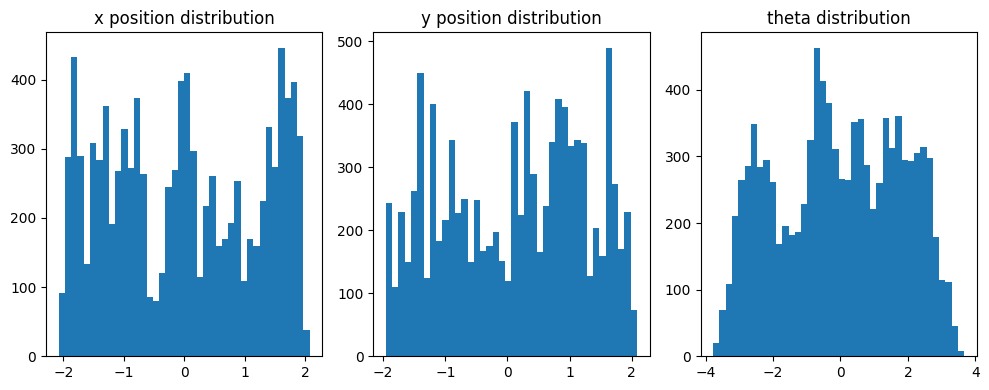

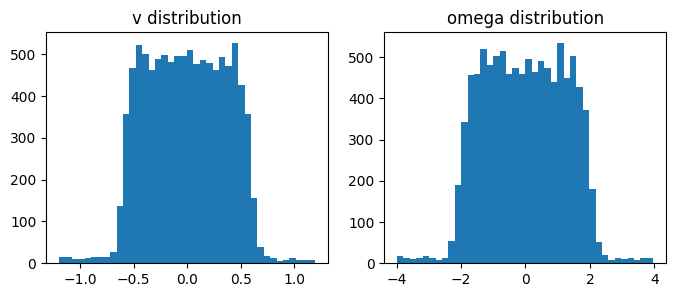

In [3]:
start_time = time.time()
# Data Collection
N_traj = 200 # number of short trajectories
T_per = 50 # timesteps per trajectory

# ranges for random initial states and inputs (to ensure coverage)
x0_range = np.array([[-2.0, 2.0], [-2.0, 2.0], [-np.pi, np.pi]])

# Input excitation: piecewise-constant random signals with occasional bursts
u_v_range = [-0.6, 0.6] # linear velocity range
u_w_range = [-2.0, 2.0] # angular velocity range

X = [] # states at time t
Y = [] # states at time t+1
U = [] # inputs at time t

for traj in range(N_traj):
    # random initial state
    x0 = np.array([np.random.uniform(*x0_range[0]),
    np.random.uniform(*x0_range[1]),
    np.random.uniform(*x0_range[2])])
    state = x0.copy()
    for t in range(T_per):
        # persistently exciting input: mix of low amplitude noise + random pulses
        if np.random.rand() < 0.05:
            v = np.random.uniform(-1.2, 1.2)
            w = np.random.uniform(-4.0, 4.0)
        else:
            v = np.random.uniform(*u_v_range) + 0.05*np.random.randn()
            w = np.random.uniform(*u_w_range) + 0.2*np.random.randn()
        u = np.array([v, w])
        next_state = f_discrete(state, u, dt=dt)
        X.append(state.copy())
        Y.append(next_state.copy())
        U.append(u.copy())
        state = next_state

X = np.array(X).T # shape (3, M)
Y = np.array(Y).T
U = np.array(U).T
M = X.shape[1]
print(f"Collected {M} data pairs from {N_traj} trajectories.")

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.3f} seconds")

# Plot distribution of collected data
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(X[0,:], bins=40)
plt.title('x position distribution')
plt.subplot(1,3,2)
plt.hist(X[1,:], bins=40)
plt.title('y position distribution')
plt.subplot(1,3,3)
plt.hist(X[2,:], bins=40)
plt.title('theta distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(U[0,:], bins=40)
plt.title('v distribution')
plt.subplot(1,2,2)
plt.hist(U[1,:], bins=40)
plt.title('omega distribution')
plt.show()

### Step 2: Determine Your Dictionary of Lifting Functions

The next step is to choose a set of lifting functions that map your original state and input to a higher-dimensional space where the dynamics become approximately linear. Common choices for these nonlinear functions include polynomials, radial basis functions, or neural networks. The exact form can significantly influence model performance, and we recommend referring to the literature for guidance on selecting an appropriate dictionary. Here we provide a general class and give some examples. For simplicity, we didn't include the NN-based construction here but you can refer to our another work ([K-RSR](https://github.com/lengtx20/Koopman4Rob)) for advanced settings.

Note that here we also provide a parameter to configure how the input is incorporated into the lifted space. You can select between a co-affine or bilinear formulation. Please see the accompanying paper for a detailed discussion of these configurations and their trade-offs.

In [4]:
from itertools import combinations_with_replacement

class Lifting:
    def __init__(self, n_states=3, n_inputs=2, poly_order=2, use_trig=True, include_u_in_phi=False, cross_terms=False):
        self.n = n_states
        self.m = n_inputs
        self.poly_order = poly_order
        self.use_trig = use_trig
        self.include_u_in_phi = include_u_in_phi
        self.cross_terms = cross_terms
        # build index map for polynomial terms
        self.poly_terms = self._poly_term_indices(self.n, self.poly_order)

    def _poly_term_indices(self, n, order):
        # returns list of exponent tuples for monomials up to given order (excluding constant)
        terms = []
        for deg in range(1, order+1):
            # generate combinations of exponents that sum to deg using stars and bars is tricky; we brute force small n
            # We'll enumerate all tuples of length n with non-negative ints summing to deg
            def rec_build(prefix, k, remain):
                if k==0:
                    if remain==0:
                        terms.append(tuple(prefix))
                    return
                for val in range(remain+1):
                    rec_build(prefix+[val], k-1, remain-val)
            rec_build([], n, deg)
        return terms

    def phi(self, x, u=None):
        # x shape (n,) ; u shape (m,) or None
        feats = []
        # identity terms
        feats.extend(x.tolist())
        # polynomial terms
        for exps in self.poly_terms:
            val = 1.0
            for xi, e in zip(x, exps):
                if e!=0:
                    val *= (xi**e)
            feats.append(val)
        # trigonometric on theta if present (assumes theta is third state index)
        if self.use_trig and self.n>=3:
            theta = x[2]
            feats.append(np.cos(theta))
            feats.append(np.sin(theta))
        # cross terms between states optionally
        if self.cross_terms:
            for i in range(self.n):
                for j in range(i+1, self.n):
                    feats.append(x[i]*x[j])
        # include inputs into phi optionally
        if self.include_u_in_phi and u is not None:
            feats.extend(u.tolist())
            # also polynomial in inputs
            for ui in u:
                feats.append(ui)
                feats.append(ui**2)
        return np.array(feats)

    def dim(self):
        # estimate dimension using zero inputs and zero x
        z = self.phi(np.zeros(self.n), np.zeros(self.m) if self.include_u_in_phi else None)
        return z.size

# Show example lifting choices
lift1 = Lifting(poly_order=2, use_trig=True, include_u_in_phi=False, cross_terms=True)
print('Example phi dimension (no u):', lift1.dim())

lift2 = Lifting(poly_order=3, use_trig=False, include_u_in_phi=True, cross_terms=False)
print('Example phi dimension (with u included):', lift2.dim())

# print small sample lifted outputs
sample_x = np.array([0.5, -0.2, 0.3])
sample_u = np.array([0.4, -0.7])
print('\nSample original x:', sample_x)
print('Phi(x) with lift1:', lift1.phi(sample_x))
print('Phi(x,u) with lift2:', lift2.phi(sample_x, sample_u))

Example phi dimension (no u): 17
Example phi dimension (with u included): 28

Sample original x: [ 0.5 -0.2  0.3]
Phi(x) with lift1: [ 0.5        -0.2         0.3         0.3        -0.2         0.5
  0.09       -0.06        0.04        0.15       -0.1         0.25
  0.95533649  0.29552021 -0.1         0.15       -0.06      ]
Phi(x,u) with lift2: [ 0.5   -0.2    0.3    0.3   -0.2    0.5    0.09  -0.06   0.04   0.15
 -0.1    0.25   0.027 -0.018  0.012 -0.008  0.045 -0.03   0.02   0.075
 -0.05   0.125  0.4   -0.7    0.4    0.16  -0.7    0.49 ]


### Step 3: Koopman Operator Estimation
Once the data and dictionary are prepared, you can proceed to estimate the Koopman operator. Various methods exist for this fitting process, and we refer you to the literature for a comprehensive overview. As a concrete example, we provide an implementation of the Extended Dynamic Mode Decomposition (EDMD) method. The core step is to solve for the operator K using the linear least-squares solution。

In [5]:
start_time = time.time()
# We will form Phi(X) and Phi(Y) and solve for K such that Phi(Y) = K * [Phi(X); U]
# i.e. K * Z = Yphi  where Z = [Phi(X); U]
# choose a lifting
lifting = Lifting(poly_order=1, use_trig=True, include_u_in_phi=False, cross_terms=True)

# Build Phi matrices
PhiX = np.vstack([lifting.phi(X[:,i]) for i in range(M)]).T  # (N_phi, M)
PhiY = np.vstack([lifting.phi(Y[:,i]) for i in range(M)]).T

# Build composite Z = [PhiX; U]
Z = np.vstack([PhiX, U])  # shape (N_phi + m, M)

# EDMD with inputs: K = PhiY * pinv(Z)
K_edmd = PhiY.dot(pinv(Z))

N_phi = PhiX.shape[0]
K_phi = K_edmd[:, :N_phi]
K_u = K_edmd[:, N_phi:]
print(f"Estimated K_phi shape: {K_phi.shape}, K_u shape: {K_u.shape}")

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.3f} seconds")

Estimated K_phi shape: (11, 11), K_u shape: (11, 2)
⏱️ Execution time: 0.363 seconds


In [6]:
start_time = time.time()
# Determine predictor matrix C that maps phi(x) -> original x
C = X.dot(pinv(PhiX))  # shape (n, N_phi)
print('C shape:', C.shape)

# Check how well C reconstructs states from phi
X_rec = C.dot(PhiX)
recon_error = np.linalg.norm(X - X_rec)/np.sqrt(M)
print(f'Reconstruction RMS error on training data: {recon_error:.5f}')

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.3f} seconds")

C shape: (3, 11)
Reconstruction RMS error on training data: 0.00000
⏱️ Execution time: 0.023 seconds


⏱️ Execution time: 0.062 seconds


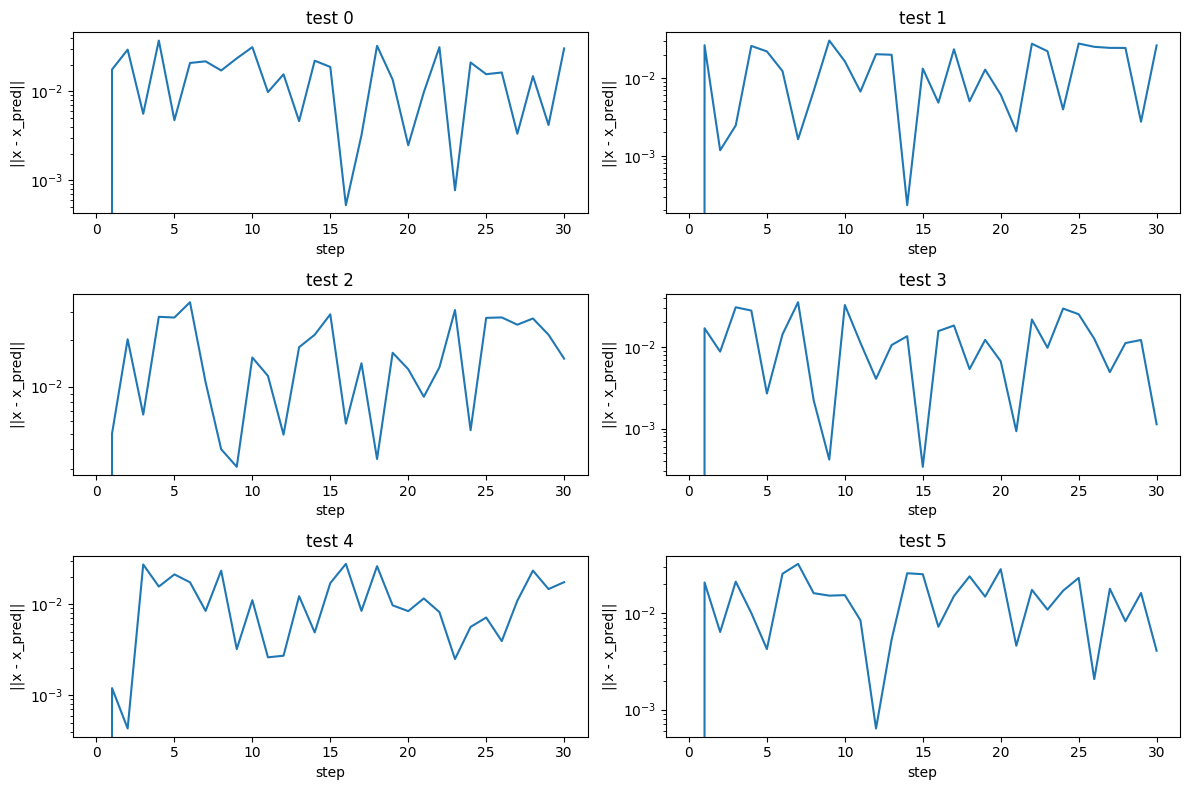

Mean error at final step across tests: 0.015733598689317785


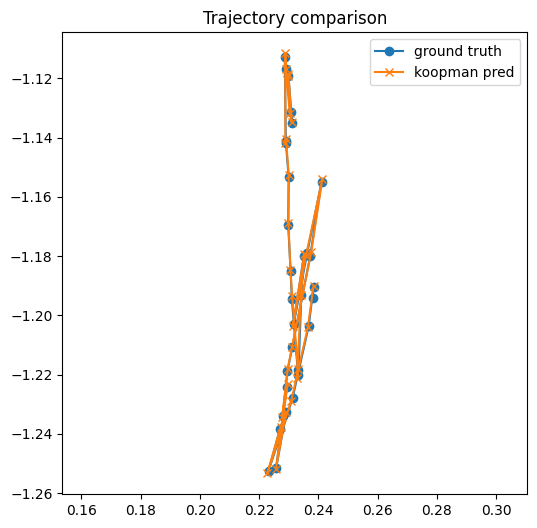

In [7]:
# Check Prediction Performance

# We'll pick some random initial states from the dataset and roll out predictions
# both in lifted space (phi) and map back to state space with C, compare to groundtruth.
def koopman_predict_rollout(x0, u_seq, K_phi, K_u, C, lifting, steps):
    phi = lifting.phi(x0)
    xs = [x0.copy()]
    x_next = x0.copy()
    preds = [x0.copy()]
    for t in range(steps):
        u = u_seq[:,t]
        phi = K_phi.dot(lifting.phi(x_next)) + K_u.dot(u)
        x_pred = C.dot(phi)
        preds.append(x_pred.copy())
        # simulate true system to get groundtruth next state
        x_next = f_discrete(xs[-1], u, dt=dt)
        xs.append(x_next)
    return np.array(xs).T, np.array(preds).T

start_time = time.time()
# test on a few random segments from the collected data
n_tests = 6
horizon = 30
errors = []
plt.figure(figsize=(12,8))
for i in range(n_tests):
    idx = np.random.randint(0, M-horizon)
    x0 = X[:,idx]
    u_seq = U[:, idx:idx+horizon]
    xs, preds = koopman_predict_rollout(x0, u_seq, K_phi, K_u, C, lifting, horizon)
    # compute error over horizon
    err = np.linalg.norm(xs - preds, axis=0)  # per timestep
    errors.append(err)
    plt.subplot(3,2,i+1)
    plt.plot(err)
    plt.yscale('log')
    plt.xlabel('step'); plt.ylabel('||x - x_pred||'); plt.title(f'test {i}')

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.3f} seconds")

plt.tight_layout()
plt.show()

# aggregate
errors = np.array(errors)
print('Mean error at final step across tests:', np.mean(errors[:,-1]))

# Plot one example of trajectory comparison in xy plane
idx = np.random.randint(0, M-horizon)
x0 = X[:,idx]
u_seq = U[:, idx:idx+horizon]
xs, preds = koopman_predict_rollout(x0, u_seq, K_phi, K_u, C, lifting, horizon)
plt.figure(figsize=(6,6))
plt.plot(xs[0,:], xs[1,:], '-o', label='ground truth')
plt.plot(preds[0,:], preds[1,:], '-x', label='koopman pred')
plt.legend(); plt.axis('equal'); plt.title('Trajectory comparison');
plt.show()

### Step 4: Use the Learned Model for Your Downstream Applications!

Now you are ready to use the learned Koopman model for your own application!
Once a linear approximation of the nonlinear dynamics is obtained in the lifted space, it can be seamlessly applied to many downstream tasks such as state estimation, planning and localization, and controller design. (More examples can be found in the paper.)

In this tutorial, we demonstrate one example — a Koopman-based Model Predictive Controller (MPC) that drives a differential drive robot to track a desired reference trajectory. It is important to note that throughout this process, we assume no prior knowledge of the robot’s physical model.
Both modeling and control are derived purely from data, highlighting the Koopman framework’s model-free yet interpretable nature. Moreover, since the control is performed in a high-dimensional linear Koopman space, the MPC optimization remains convex and computationally efficient, enabling real-time operation.

Here our goal is not to achieve the best performance but to help you understand the overall pipeline — how a Koopman model can be directly used for control once trained from data. If you want a better performance of this controller, it can be improved in several intuitive ways: by tuning the MPC parameters, changing the lifting function dictionary, or providing richer training data. For instance, since we know this is a differential-drive robot, setting use_trig=True in the lifting function allows the model to better capture the angular behavior, leading to smoother and more accurate control.

⏱️ Execution time: 37.955 seconds


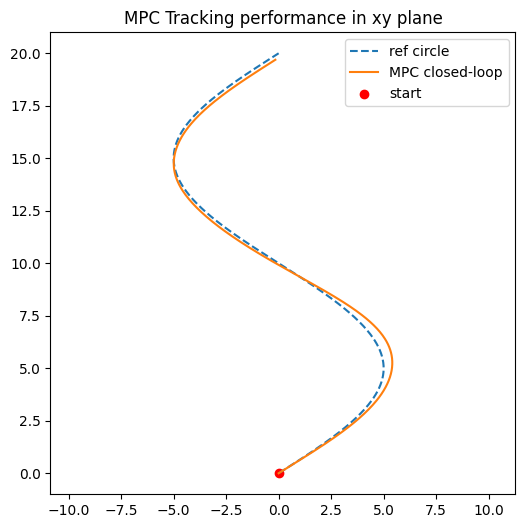

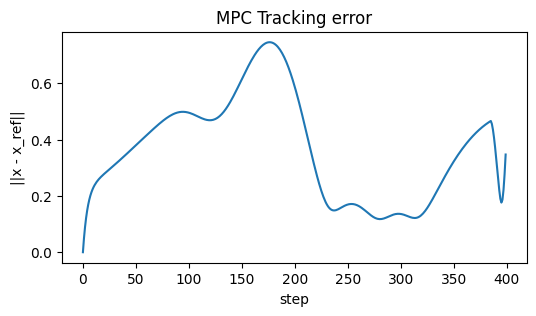

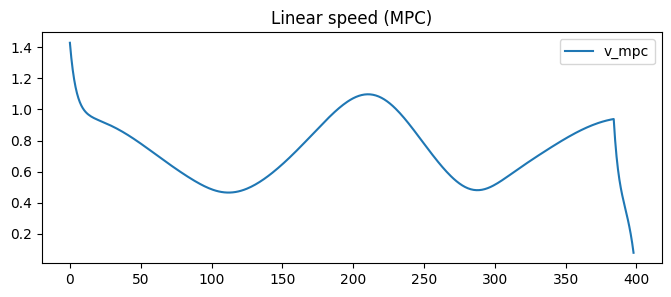

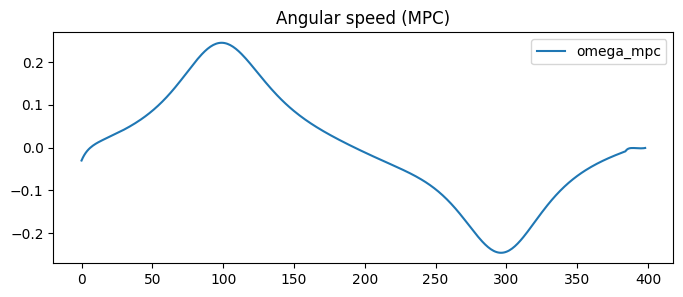

In [8]:
start_time = time.time()

import cvxpy as cp

A_l = K_phi
B_l = K_u

T_track = 400
t_grid = np.arange(T_track)
dt = 0.1
nx = 3  # [x, y, yaw]

# Create the reference trajectory
A=5.0
L=20.0

# Longitudinal progression (y increases linearly)
t = np.linspace(0, T_track * dt, T_track)
y = L * (t / (T_track * dt))  # y moves from 0 to L

# Lateral oscillation (sinusoidal x variation)
x = A * np.sin(2 * np.pi * y / L)

# Heading direction is tangent to the curve
dy = np.gradient(y)
dx = np.gradient(x)
theta = np.arctan2(dy, dx)

# Wrap theta smoothly to avoid jumps
theta = np.unwrap(theta)

# Combine to reference trajectory
x_ref = np.vstack((x, y, theta))
x0 = x_ref[:, 0].copy()

# compute approximate nominal velocities only for reference visualization (not used in MPC cost)
x_ref_dot = np.zeros_like(x_ref)
for k in range(T_track-1):
    x_ref_dot[:,k] = (x_ref[:,k+1] - x_ref[:,k]) / dt
nu_ref_vis = np.zeros((2,T_track))
for k in range(T_track-1):
    v = np.hypot(x_ref_dot[0,k], x_ref_dot[1,k])
    omega = (x_ref[2,k+1] - x_ref[2,k]) / dt
    omega = (omega + np.pi) % (2*np.pi) - np.pi
    nu_ref_vis[0,k] = v
    nu_ref_vis[1,k] = omega
nu_ref_vis[:, -1] = nu_ref_vis[:, -2]

# Build lifted reference Phi_ref by applying lifting.phi to each x_ref
Phi_ref = np.vstack([lifting.phi(x_ref[:,k]) for k in range(T_track)]).T  # shape (N_phi, T_track)

# MPC parameters
N_mpc = 15  # horizon (in timesteps)
Q_mpc = np.eye(A_l.shape[0]) * 0.1
Q_mpc[:nx,:nx] = np.diag([10, 10, 0.1])  # x, y, yaw
R_mpc = np.eye(B_l.shape[1]) * 0.1

u_min = np.array([-1.5, -5.0]) # -1.5, -5.0
u_max = np.array([1.5, 5.0])

# Pre-allocate simulation arrays
T_track = Phi_ref.shape[1]
x_mpc = np.zeros((3, T_track))
x_mpc[:,0] = x_ref[:,0] # np.array([0,0,np.pi/2])
u_mpc_hist = np.zeros((2, T_track-1))

# Main receding-horizon MPC loop
for k in range(T_track-1):
    # horizon length (shorten near end)
    H = min(N_mpc, T_track-1-k)
    # decision variables: U = [u_0, ..., u_{H-1}] stacked
    Uvar = cp.Variable((B_l.shape[1], H))
    Phivar = cp.Variable((A_l.shape[0], H+1))

    # parameters / constants
    phi0 = lifting.phi(x_mpc[:,k])
    phi_ref_h = Phi_ref[:, k:k+H+1]

    cost = 0
    constraints = []
    # initial condition
    constraints += [Phivar[:,0] == phi0]
    # dynamics and cost
    for t in range(H):
        # dynamics
        constraints += [Phivar[:,t+1] == A_l@(Phivar[:,t]) + B_l@(Uvar[:,t])]
        # input bounds
        constraints += [Uvar[:,t] <= u_max, Uvar[:,t] >= u_min]
        # stage cost: (phi-phi_ref)'Q(phi-phi_ref) + u'R u
        phi_err = Phivar[:,t] - phi_ref_h[:,t]
        u_var = Uvar[:,t]
        cost += cp.quad_form(phi_err, Q_mpc) + cp.quad_form(u_var, R_mpc)
    # terminal cost
    phi_term_err = Phivar[:,H] - phi_ref_h[:,H]
    cost += cp.quad_form(phi_term_err, Q_mpc)

    # solve QP
    prob = cp.Problem(cp.Minimize(cost), constraints)
    try:
        prob.solve(warm_start=True, verbose=False)
    except Exception:
        prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)

    if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        print(f"Warning: solver status at step {k}: {prob.status}")
    # apply first control
    u_opt = None
    if Uvar.value is not None:
        u_opt = Uvar.value[:,0]
    if u_opt is None:
        # solver failed — fallback to zero input (no feedforward assumed)
        u_opt = np.zeros(B_l.shape[1])
    # clip and store
    u_cmd = np.clip(u_opt, u_min, u_max)
    u_mpc_hist[:,k] = u_cmd
    # step true nonlinear system
    x_mpc[:,k+1] = f_discrete(x_mpc[:,k], u_cmd, dt=dt)

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.3f} seconds")

# plot tracking results
plt.figure(figsize=(6,6))
plt.plot(x_ref[0,:], x_ref[1,:], '--', label='ref circle')
plt.plot(x_mpc[0,:], x_mpc[1,:], '-', label='MPC closed-loop')
plt.scatter(x_mpc[0,0], x_mpc[1,0], c='r', label='start')
plt.axis('equal'); plt.legend(); plt.title('MPC Tracking performance in xy plane')
plt.show()

err_mpc = np.linalg.norm(x_ref - x_mpc, axis=0)
plt.figure(figsize=(6,3))
plt.plot(err_mpc)
plt.xlabel('step'); plt.ylabel('||x - x_ref||'); plt.title('MPC Tracking error');
plt.show()

plt.figure(figsize=(8,3))
plt.plot(u_mpc_hist[0,:], label='v_mpc')
plt.legend(); plt.title('Linear speed (MPC)')
plt.show()

plt.figure(figsize=(8,3))
plt.plot(u_mpc_hist[1,:], label='omega_mpc')
plt.legend(); plt.title('Angular speed (MPC)')
plt.show()

# %%
# Save minimal results if desired
# np.savez('koopman_diffdrive_data.npz', X=X, Y=Y, U=U, K_phi=K_phi, K_u=K_u, C=C)
